In [1]:
# FLORIDA INTERNATIONAL UNIVERSITY (FIU)
# EEL6812 - ADVANCED TOPICS IN NEURAL NETWORKS (DEEP LEARNING)
# MOLTO, JOAQUIN (PID: 6119985)
# HW ASSIGNMENT #2 - CONVOLUTIONAL NEURAL NETWORKS
# DUE DATE: 04/10/2024

# PVDM CLASSIFIERS (1=PANDA,0=NOT PANDA/DOG)

In [2]:
# BRING NECESSARY FILES INTO THE SESSION
from google.colab import files
import os, shutil, pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# INSTALL KAGGLE IF NOT ALREADY INSTALLED AND IMPORT KAGGLE.JSON INTO THE SESSION
!pip install kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joaquinmolto","key":"d560844e63fba9ee27160fbc32ee7f50"}'}

In [4]:
# CREATES THE KAGGLE DIRECTORY IN THE SESSION, COPIES JSON FILE OVER, GRANTS PERMISSION USING CHMOD
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# USE KAGGLE CLI TO DOWNLOAD THE DATASET
!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

 99% 373M/376M [00:09<00:00, 44.7MB/s]
100% 376M/376M [00:09<00:00, 41.2MB/s]


In [6]:
!unzip -qq animal-image-datasetdog-cat-and-panda.zip

**PART I. INITIAL REORGANIZATION OF THE DATA**


*   TRAIN **[TR]** = 700 patterns/samples each
*   VALIDATION **[TT]** = 700 pattern/sample each
*   TESTING **[TS]** = 700 pattern/sample each

Acknowledgement to Dr. Barreto for this portion of the Jupyter Notebook, as his code facilitated the creation of the subdirectories with the split data

In [7]:
# DR. BARRETO'S DATA PREPARATION CODE
original_dir = pathlib.Path('animals')
new_base_dir = pathlib.Path('newanim')
def make_subset(subset_name, start_index, end_index):
  for category in ('cats', 'dogs', 'panda'):
    dir = new_base_dir / subset_name / category
    dirsrc = original_dir / category
    os.makedirs(dir)
    fnames = ['{}_{:05d}.jpg'.format(category, i)
                  for i in range(start_index, end_index)]
    for fname in fnames:
     shutil.copyfile(src=dirsrc / fname , dst=dir / fname)

    #print(fnames)
    #print(dirsrc)
    #print(dir)
# make_subset('train', start_index=0, end_index=1000)
# make_subset('validation', start_index=1000, end_index=1500)
# # make_subset('test', start_index=1500, end_index=2500)

make_subset('train', start_index=1, end_index=701) # will grab first 700 .jpeg files for Cats, Dogs, and Pandas
make_subset('validation', start_index=701, end_index=901) # will grab remaining 200 .jpeg files for Cats, Dogs, and Pandas
make_subset('test', start_index=901, end_index=1001) # will grab last 100 .jpeg files for Cats, Dogs, Pandas (TOTAL: 1,000 FILES PER CLASS)

In [8]:
# verify the 3 subdirectories were created
!ls -l ./newanim/

total 12
drwxr-xr-x 5 root root 4096 Apr 11 04:10 test
drwxr-xr-x 5 root root 4096 Apr 11 04:10 train
drwxr-xr-x 5 root root 4096 Apr 11 04:10 validation


**PART II. DOGS VERSUS PANDAS CLASSIFIER**

Before we start building the Convolutional Neural Network (CNN) and the Fully-Connected or Dense Neural Network, we must remove the cat subdirectories for TR, TT, TS folders

In [9]:
# REMOVE ALL 3 CAT SUBDIRECTORIES FROM THE TRAINING, VALIDATION, AND TESTING FOLDERS
!rm -r ./newanim/train/cats/
!rm -r ./newanim/validation/cats/
!rm -r ./newanim/test/cats/

In [10]:
# ENSURE THE CAT SUBDIRECTORY IS GONE FROM THESE THREE SUBDIRECTORIES
!dir ./newanim/train
!dir ./newanim/validation
!dir ./newanim/test

dogs  panda
dogs  panda
dogs  panda


In [11]:
# NOW, WE HAVE CREATE THE TF (TENSORFLOW) DATASET
train_dataset = image_dataset_from_directory(
	new_base_dir / 'train',
	image_size=(180, 180),
	batch_size=32)
validation_dataset = image_dataset_from_directory(
	new_base_dir / 'validation',
	image_size=(180, 180),
	batch_size=32)
test_dataset = image_dataset_from_directory(
 	new_base_dir / 'test',
  	image_size=(180, 180),
   	batch_size=32)

Found 1400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


Therefore, our directory structure now looks like this:

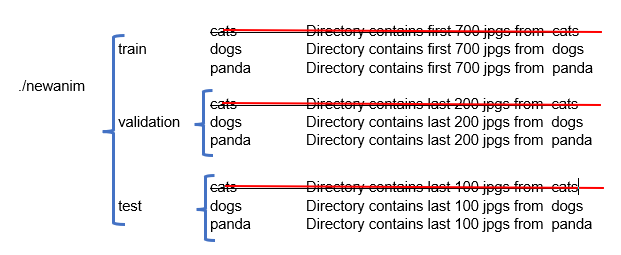

**PART II.1 DOGS VERSUS PANDAS CLASSIFIER (PVDM1)**

Develop a first, relatively simple CNN model named pvdm1 to classify Dogs versus Pandas

RESTRICTIONS:


1.   CANNOT USE DROPOUT
2.   CANNOT USE L1 OR L2 NORM PARAMETER REGULARIZATION
3.   CANNOT USE DATA AUGMENTATION


PVDM1 Architecture:

*   2D Convolutional Neural Network (CNN)
**   3x3 Kernels/Filters (32 of them)
**   MaxPool 2D Layer (size 2)
*   2D Convolutional Neural Network (CNN)
**   3x3 Kernels/Filters (32 of them)
**   MaxPool 2D Layer (size 2)
*   2D Convolutional Neural Network (CNN)
**   3x3 Kernels/Filters (32 of them)
**   MaxPool 2D Layer (size 2)
* Flattening Layer (Rank-1 Tensor)
* Fully-Connected/Dense Network (DNN)
** HL01: 128 PE with ReLU activation
** OL: 1 PE with Sigmoid activation

In [12]:
# PREPROCESS THE IMAGES TO HAVE CONSISTENT DIMENSIONS AND PERFORM PIXEL NORMALIZATION

# while the instructions impede the use of neuron dropout, L1/L2 weight regularization, and data augmentation for the first model pvdm1
# I will perform pixel-wise normalization by dividing by 255

# IMAGE PREPROCESSING FUNCTION
def normalize_image(image,label):
  return image / 255, label

# APPLY THE PREPROCESSING FUCTION TO THE TF DATASET
train_dataset = train_dataset.map(normalize_image)
validation_dataset = validation_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

In [13]:
# DEFINE MODEL ARCHITECTURE FOR PVDM01 USING KERAS SEQUENTIAL API
pvdm1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [14]:
# COMPILE THE MODEL
pvdm1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
# SET UP CALLBACK SO THAT WE CAN RETURN THE MODEL (.KERAS) FILE WHOSE WEIGHTS ACHIEVED THE LOWEST VALIDATION LOSS

# SPECIFY THE PATH TO SAVE THE BEST MODEL
model_save_path = "best_model.keras"

# SET UP THE MODEL_CHECKPOINT_CALLBACK MONITORING THE VAL_LOSS
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_save_path,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)


In [ ]:
# FIT THE MODEL
history = pvdm1.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=[model_checkpoint_callback])

In [17]:
# PRINT THE MODEL SUMMARY
pvdm1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 128)       0

In [18]:
# EVALUATE THE MODEL
test_loss, test_accuracy = pvdm1.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

7/7 [==============================] - 0s 21ms/step - loss: 0.3370 - accuracy: 0.9300
Test Loss: 0.33695125579833984
Test Accuracy: 0.9300000071525574


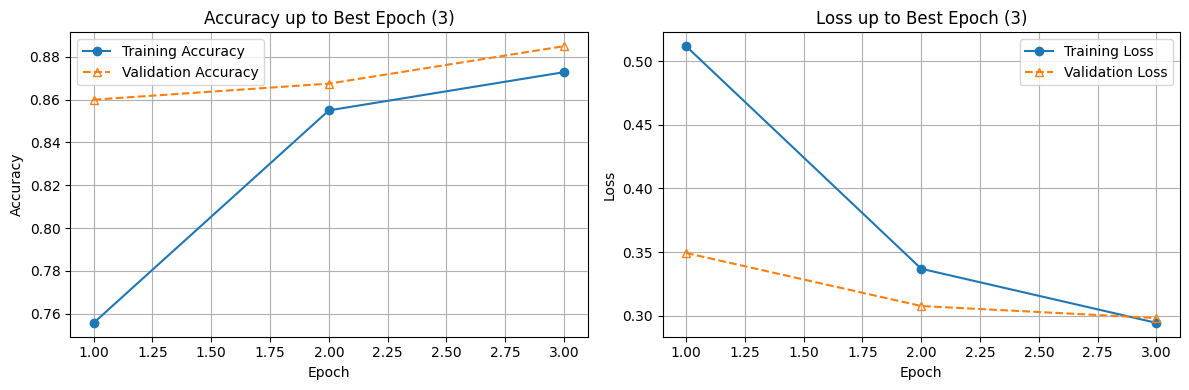

In [19]:
def plot_history_until_best_epoch_modified(history):
    # Find the epoch number where the validation loss was minimum; epochs are 1-indexed in the plot
    min_val_loss_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1

    # Prepare the range for plotting
    epochs_range = range(1, min_val_loss_epoch + 1)

    plt.figure(figsize=(12, 4))

    # Plot Accuracy with markers and grid
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'][:min_val_loss_epoch], 'o-', label='Training Accuracy')  # Circle markers, solid line
    plt.plot(epochs_range, history.history['val_accuracy'][:min_val_loss_epoch], marker='^', linestyle='--', fillstyle='none', label='Validation Accuracy')  # Triangle markers, dashed line
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy up to Best Epoch ({min_val_loss_epoch})')
    plt.legend()
    plt.grid(True)  # Display gridlines

    # Plot Loss with markers and grid
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'][:min_val_loss_epoch], 'o-', label='Training Loss')  # Circle markers, solid line
    plt.plot(epochs_range, history.history['val_loss'][:min_val_loss_epoch], marker='^', linestyle='--', fillstyle='none', label='Validation Loss')  # Triangle markers, dashed line
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss up to Best Epoch ({min_val_loss_epoch})')
    plt.legend()
    plt.grid(True)  # Display gridlines

    plt.tight_layout()
    plt.show()

# Call the function with the history variable
plot_history_until_best_epoch_modified(history)

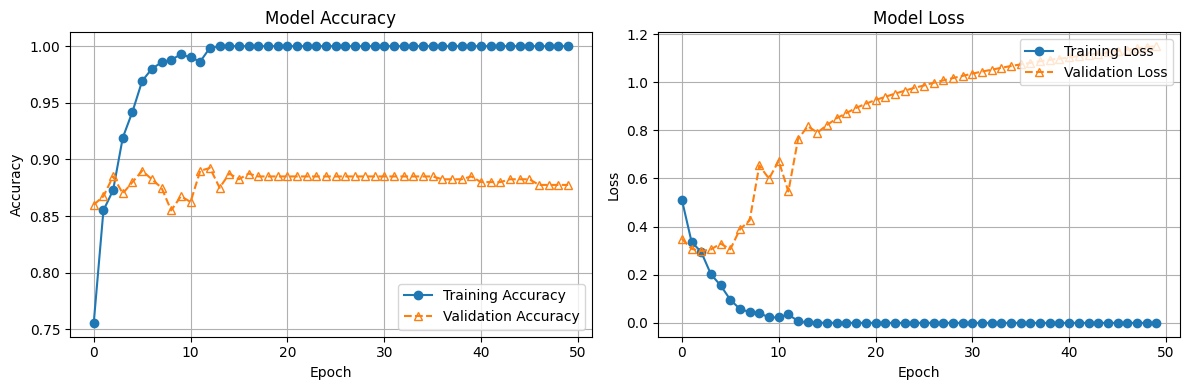

In [20]:
# PLOT THE TRAINING AND VALIDATION CURVES

# Prepare the figure
plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')  # Circle markers, solid line for Training
plt.plot(history.history['val_accuracy'], '^', linestyle='--', fillstyle='none', label='Validation Accuracy')  # Triangle markers, dashed line for Validation
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)  # Display gridlines

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['loss'], 'o-', label='Training Loss')  # Circle markers, solid line for Training
plt.plot(history.history['val_loss'], marker='^', linestyle='--', fillstyle='none', label='Validation Loss')  # Triangle markers, dashed line for Validation
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)  # Display gridlines

# Display the plots
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 77ms/step


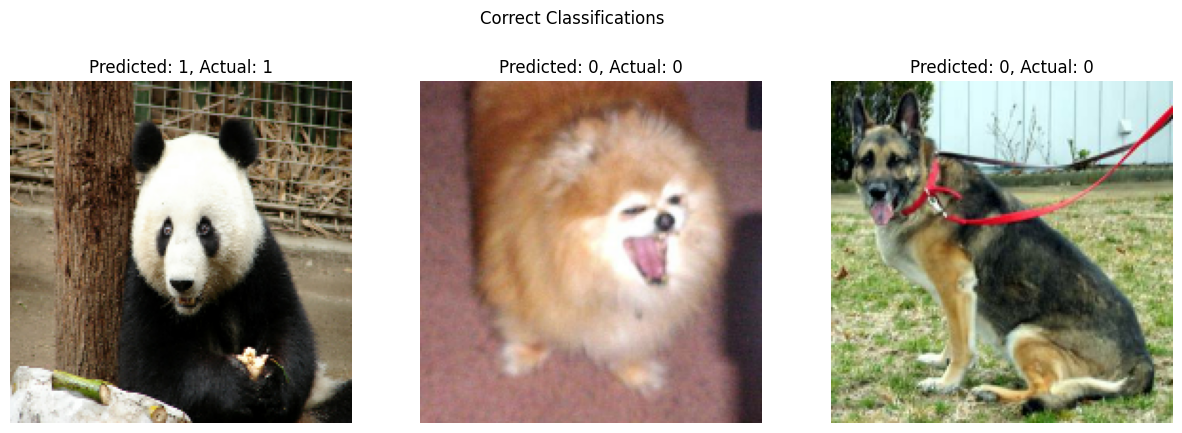

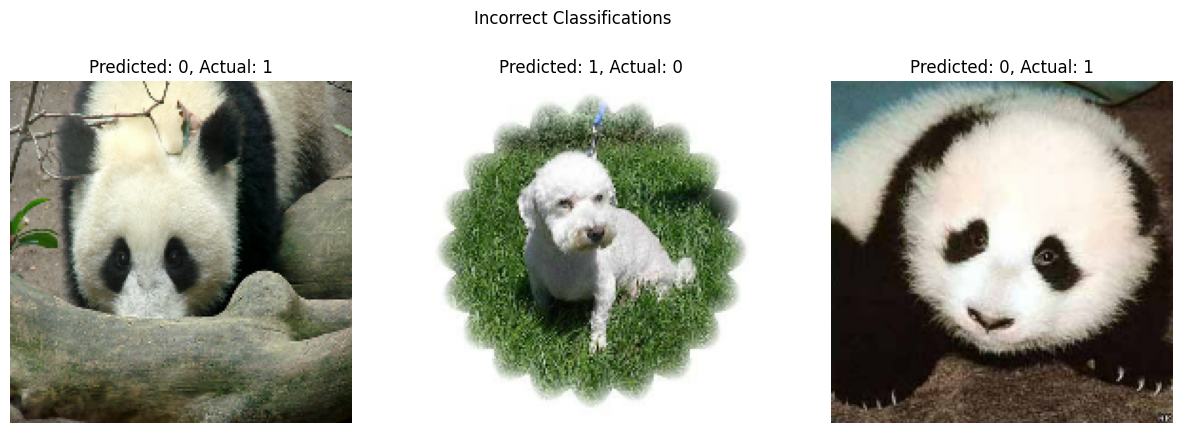

In [21]:
# Assuming test_dataset is batched: (image, label)
predictions = []
labels = []
images = []
for img, label in test_dataset.take(10):  # Adjust the number of batches to suit your dataset size
    pred = pvdm1.predict(img)
    pred = np.round(pred).astype(int).flatten()  # Round predictions to 0 or 1 for binary classification
    predictions.extend(pred)
    labels.extend(label.numpy())
    images.extend(img.numpy())

# Convert lists to arrays for easier manipulation
predictions = np.array(predictions)
labels = np.array(labels)
images = np.array(images)

# Find indices of correct and incorrect predictions
correct_indices = np.where(predictions == labels)[0]
incorrect_indices = np.where(predictions != labels)[0]

# Function to plot images
def plot_images(indices, title):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices[:3], start=1):  # Plot up to 3 images
        plt.subplot(1, 3, i)
        # Rescale the images back to 0-255 and convert to integers for display
        image_to_display = (images[idx] * 255).astype("uint8")
        plt.imshow(image_to_display)
        plt.title(f"Predicted: {predictions[idx]}, Actual: {labels[idx]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


# Plot correct classifications
plot_images(correct_indices, "Correct Classifications")

# Plot incorrect classifications
plot_images(incorrect_indices, "Incorrect Classifications")

**PART II.2 DOGS VERSUS PANDAS CLASSIFIER (PVDM2)**

Develop a second, further improved CNN

RESTRICTIONS:


1.   CAN USE DROPOUT (OK)
2.   CAN USE L1 OR L2 NORM PARAMETER REGULARIZATION (OK)
3.   CANNOT USE DATA AUGMENTATION (NOT OK)

PVDM2 Architecture:

*   2D Convolutional Neural Network (CNN)
** L2 (Ridge) Regularizer of $1 \times10^-3$
**   3x3 Kernels/Filters (32 of them)
**   MaxPool 2D Layer (size 2)
**   Dropout Layer of 0.25 (25%)
*   2D Convolutional Neural Network (CNN)
** L2 (Ridge) Regularizer of $1 \times10^-3$
**   3x3 Kernels/Filters (32 of them)
**   MaxPool 2D Layer (size 2)
**   Dropout Layer of 0.25 (25%)
*   2D Convolutional Neural Network (CNN)
** L2 (Ridge) Regularizer of $1 \times10^-3$
**   3x3 Kernels/Filters (32 of them)
**   MaxPool 2D Layer (size 2)
**   Dropout Layer of 0.25 (25%)
* Flattening Layer (Rank-1 Tensor)
*   Dropout Layer of 0.50 (50%)
* Fully-Connected/Dense Network (DNN)
** HL01: 128 PE with ReLU activation
** OL: 1 PE with Sigmoid activation

In [22]:
# DEFINE MODEL ARCHITECTURE FOR PVDM02 USING KERAS SEQUENTIAL API
pvdm2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1E-3), input_shape=(180, 180, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout of 25% after first pooling
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1E-3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout of 25% after second pooling
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1E-3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout of 25% after third pooling
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(1E-3)),
    Dropout(0.5), # dropout of 50% before output
    Dense(1, activation='sigmoid')
])

In [23]:
# COMPILE THE MODEL
pvdm2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
# SET UP CALLBACK SO THAT WE CAN RETURN THE MODEL (.KERAS) FILE WHOSE WEIGHTS ACHIEVED THE LOWEST VALIDATION LOSS

# SPECIFY THE PATH TO SAVE THE BEST MODEL
model_save_path = "best_model.keras"

# SET UP THE MODEL_CHECKPOINT_CALLBACK MONITORING THE VAL_LOSS
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_save_path,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)


In [ ]:
# FIT THE MODEL
history = pvdm2.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=[model_checkpoint_callback])

In [26]:
# PRINT THE MODEL SUMMARY
pvdm2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 43, 43, 64)       

In [27]:
# EVALUATE THE MODEL
test_loss, test_accuracy = pvdm2.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

7/7 [==============================] - 0s 8ms/step - loss: 0.3747 - accuracy: 0.9000
Test Loss: 0.37472572922706604
Test Accuracy: 0.8999999761581421


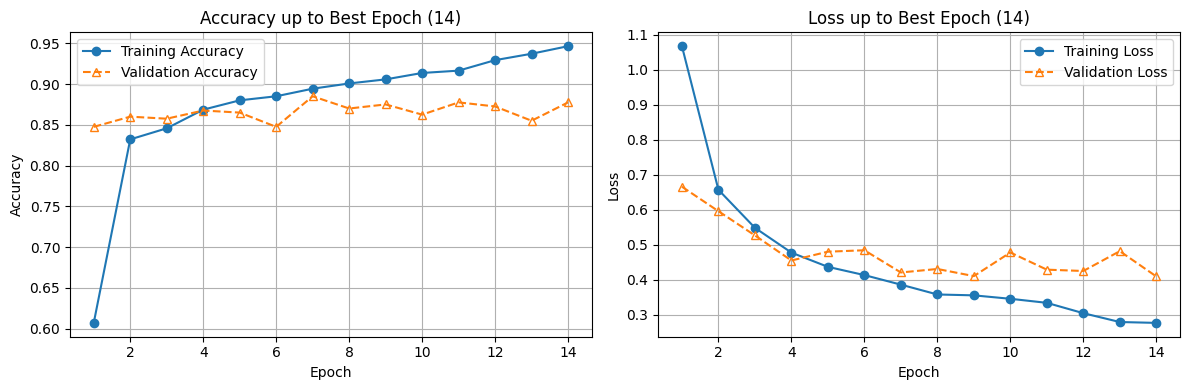

In [28]:
def plot_history_until_best_epoch_modified(history):
    # Find the epoch number where the validation loss was minimum; epochs are 1-indexed in the plot
    min_val_loss_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1

    # Prepare the range for plotting
    epochs_range = range(1, min_val_loss_epoch + 1)

    plt.figure(figsize=(12, 4))

    # Plot Accuracy with markers and grid
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'][:min_val_loss_epoch], 'o-', label='Training Accuracy')  # Circle markers, solid line
    plt.plot(epochs_range, history.history['val_accuracy'][:min_val_loss_epoch], marker='^', linestyle='--', fillstyle='none', label='Validation Accuracy')  # Triangle markers, dashed line
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy up to Best Epoch ({min_val_loss_epoch})')
    plt.legend()
    plt.grid(True)  # Display gridlines

    # Plot Loss with markers and grid
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'][:min_val_loss_epoch], 'o-', label='Training Loss')  # Circle markers, solid line
    plt.plot(epochs_range, history.history['val_loss'][:min_val_loss_epoch], marker='^', linestyle='--', fillstyle='none', label='Validation Loss')  # Triangle markers, dashed line
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss up to Best Epoch ({min_val_loss_epoch})')
    plt.legend()
    plt.grid(True)  # Display gridlines

    plt.tight_layout()
    plt.show()

# Call the function with the history variable
plot_history_until_best_epoch_modified(history)

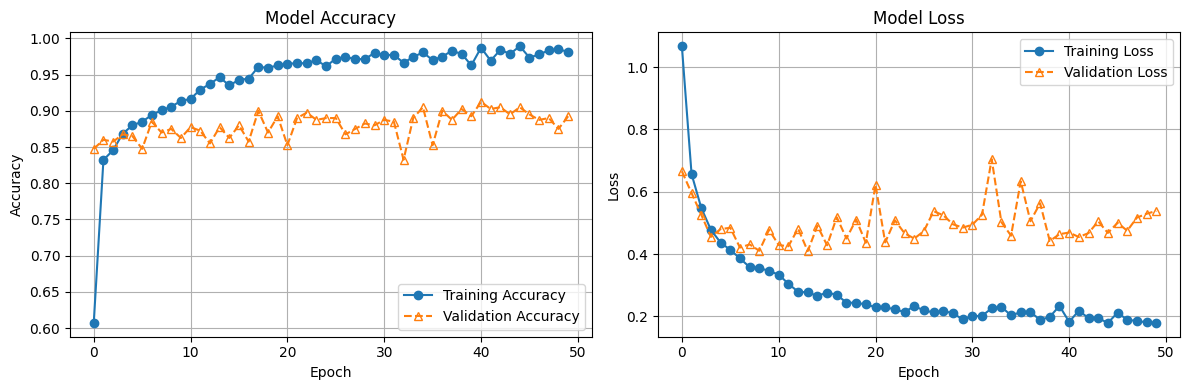

In [29]:
# PLOT THE TRAINING AND VALIDATION CURVES

# Prepare the figure
plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')  # Circle markers, solid line for Training
plt.plot(history.history['val_accuracy'], '^', linestyle='--', fillstyle='none', label='Validation Accuracy')  # Triangle markers, dashed line for Validation
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)  # Display gridlines

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['loss'], 'o-', label='Training Loss')  # Circle markers, solid line for Training
plt.plot(history.history['val_loss'], marker='^', linestyle='--', fillstyle='none', label='Validation Loss')  # Triangle markers, dashed line for Validation
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)  # Display gridlines

# Display the plots
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 78ms/step


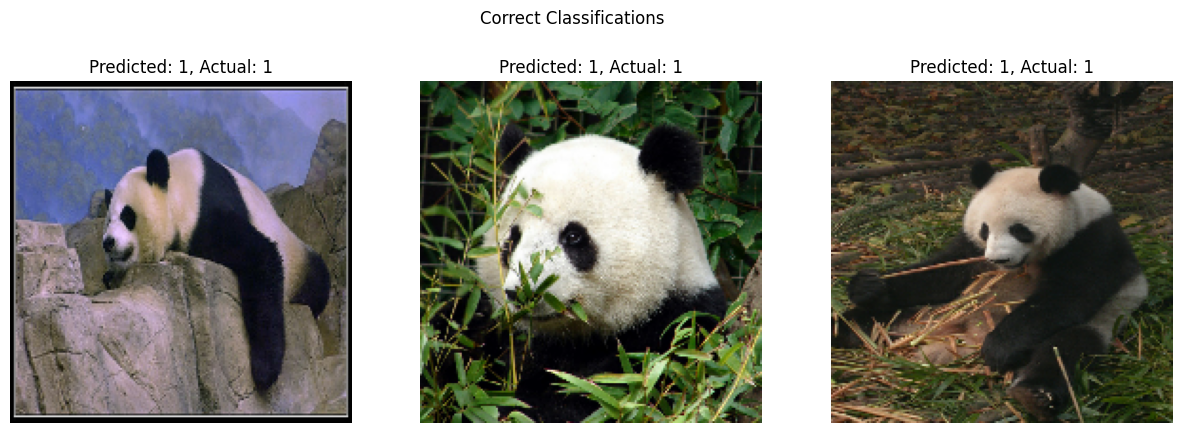

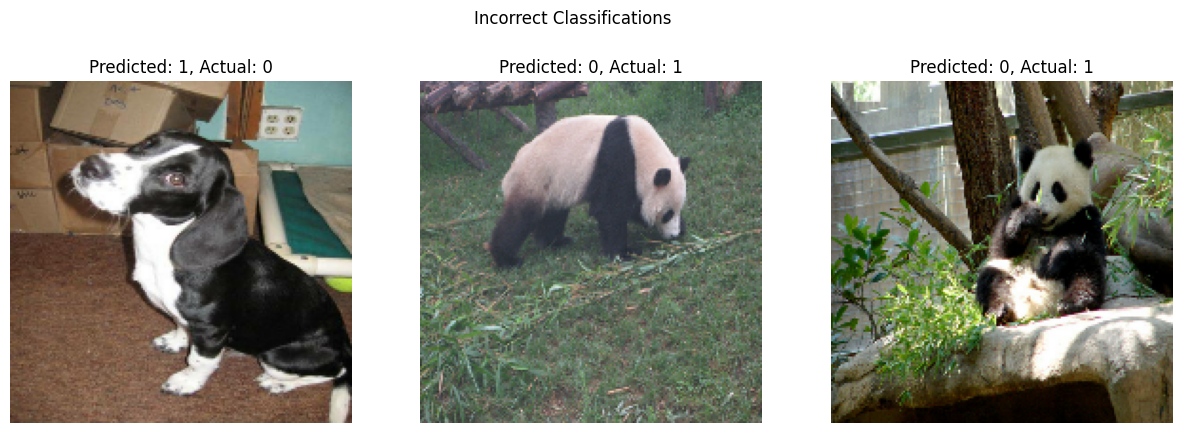

In [30]:
# Assuming test_dataset is batched: (image, label)
predictions = []
labels = []
images = []
for img, label in test_dataset.take(10):  # Adjust the number of batches to suit your dataset size
    pred = pvdm2.predict(img)
    pred = np.round(pred).astype(int).flatten()  # Round predictions to 0 or 1 for binary classification
    predictions.extend(pred)
    labels.extend(label.numpy())
    images.extend(img.numpy())

# Convert lists to arrays for easier manipulation
predictions = np.array(predictions)
labels = np.array(labels)
images = np.array(images)

# Find indices of correct and incorrect predictions
correct_indices = np.where(predictions == labels)[0]
incorrect_indices = np.where(predictions != labels)[0]

# Function to plot images
def plot_images(indices, title):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices[:3], start=1):  # Plot up to 3 images
        plt.subplot(1, 3, i)
        # Rescale the images back to 0-255 and convert to integers for display
        image_to_display = (images[idx] * 255).astype("uint8")
        plt.imshow(image_to_display)
        plt.title(f"Predicted: {predictions[idx]}, Actual: {labels[idx]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


# Plot correct classifications
plot_images(correct_indices, "Correct Classifications")

# Plot incorrect classifications
plot_images(incorrect_indices, "Incorrect Classifications")

**PART II.3 DOGS VERSUS PANDAS CLASSIFIER (PVDM3)**

Develop a third, best CNN

RESTRICTIONS:

NONE

PVDM3 Architecture:

*   2D Convolutional Neural Network (CNN)
** L2 (Ridge) Regularizer of $1 \times10^-4$
**   3x3 Kernels/Filters (32 of them)
**   MaxPool 2D Layer (size 2)
**   Dropout Layer of 0.25 (25%)
*   2D Convolutional Neural Network (CNN)
** L2 (Ridge) Regularizer of $1 \times10^-4$
**   3x3 Kernels/Filters (32 of them)
**   MaxPool 2D Layer (size 2)
**   Dropout Layer of 0.25 (25%)
*   2D Convolutional Neural Network (CNN)
** L2 (Ridge) Regularizer of $1 \times10^-4$
**   3x3 Kernels/Filters (32 of them)
**   MaxPool 2D Layer (size 2)
**   Dropout Layer of 0.25 (25%)
* Flattening Layer (Rank-1 Tensor)
*   Dropout Layer of 0.50 (50%)
* Fully-Connected/Dense Network (DNN)
** HL01: 128 PE with ReLU activation
** OL: 1 PE with Sigmoid activation

Additionally, input data was artificially augmented

In [31]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
])


In [32]:
# Assuming train_dataset is your TensorFlow dataset for training
def augment(image, label):
    # Apply the data augmentation to the images
    image = data_augmentation(image)
    return image, label

train_dataset_augmented = train_dataset.map(augment)

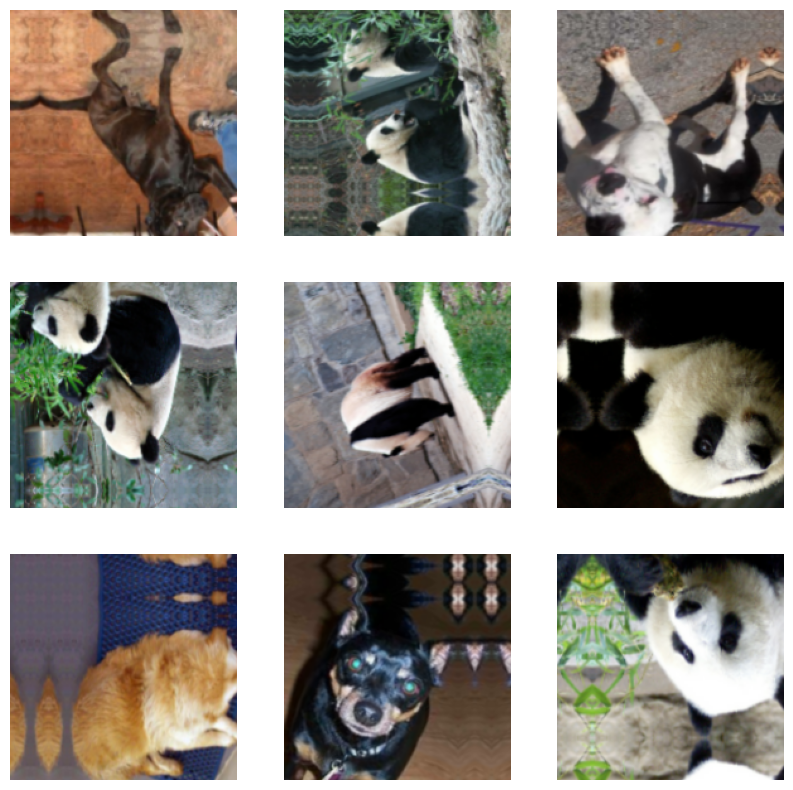

In [33]:
import matplotlib.pyplot as plt

for images, _ in train_dataset_augmented.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display 9 images from the batch
        ax = plt.subplot(3, 3, i + 1)
        # Scale the images back to [0, 255] for correct visualization
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.axis("off")
    plt.show()

In [34]:
# DEFINE MODEL ARCHITECTURE FOR PVDM02 USING KERAS SEQUENTIAL API
pvdm3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1E-4), input_shape=(180, 180, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout of 25% after first pooling
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1E-4)),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout of 25% after second pooling
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1E-4)),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # dropout of 25% after third pooling
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(1E-4)),
    Dropout(0.5), # dropout of 50% before output
    Dense(1, activation='sigmoid')
])

In [35]:
# COMPILE THE MODEL
pvdm3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [36]:
# SET UP CALLBACK SO THAT WE CAN RETURN THE MODEL (.KERAS) FILE WHOSE WEIGHTS ACHIEVED THE LOWEST VALIDATION LOSS

# SPECIFY THE PATH TO SAVE THE BEST MODEL
model_save_path = "best_model.keras"

# SET UP THE MODEL_CHECKPOINT_CALLBACK MONITORING THE VAL_LOSS
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_save_path,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)


In [ ]:
# FIT THE MODEL
history = pvdm3.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=[model_checkpoint_callback])

In [38]:
# PRINT THE MODEL SUMMARY
pvdm3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 43, 43, 64)       

In [39]:
# EVALUATE THE MODEL
test_loss, test_accuracy = pvdm3.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

7/7 [==============================] - 0s 7ms/step - loss: 0.2815 - accuracy: 0.9250
Test Loss: 0.28146037459373474
Test Accuracy: 0.925000011920929


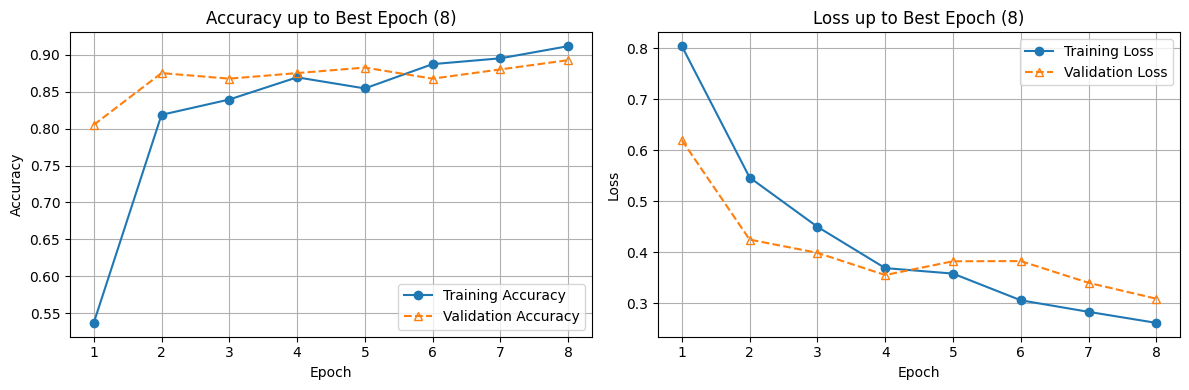

In [40]:
def plot_history_until_best_epoch_modified(history):
    # Find the epoch number where the validation loss was minimum; epochs are 1-indexed in the plot
    min_val_loss_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1

    # Prepare the range for plotting
    epochs_range = range(1, min_val_loss_epoch + 1)

    plt.figure(figsize=(12, 4))

    # Plot Accuracy with markers and grid
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'][:min_val_loss_epoch], 'o-', label='Training Accuracy')  # Circle markers, solid line
    plt.plot(epochs_range, history.history['val_accuracy'][:min_val_loss_epoch], marker='^', linestyle='--', fillstyle='none', label='Validation Accuracy')  # Triangle markers, dashed line
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy up to Best Epoch ({min_val_loss_epoch})')
    plt.legend()
    plt.grid(True)  # Display gridlines

    # Plot Loss with markers and grid
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'][:min_val_loss_epoch], 'o-', label='Training Loss')  # Circle markers, solid line
    plt.plot(epochs_range, history.history['val_loss'][:min_val_loss_epoch], marker='^', linestyle='--', fillstyle='none', label='Validation Loss')  # Triangle markers, dashed line
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss up to Best Epoch ({min_val_loss_epoch})')
    plt.legend()
    plt.grid(True)  # Display gridlines

    plt.tight_layout()
    plt.show()

# Call the function with the history variable
plot_history_until_best_epoch_modified(history)

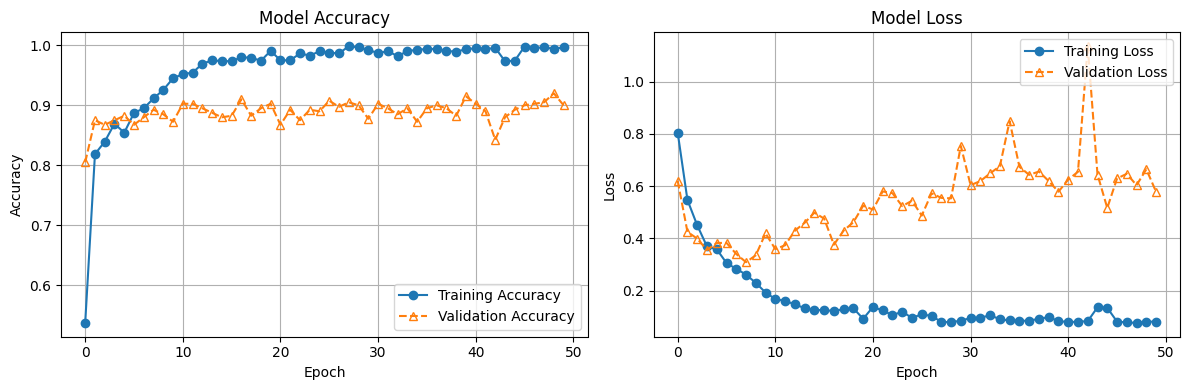

In [41]:
# PLOT THE TRAINING AND VALIDATION CURVES

# Prepare the figure
plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')  # Circle markers, solid line for Training
plt.plot(history.history['val_accuracy'], '^', linestyle='--', fillstyle='none', label='Validation Accuracy')  # Triangle markers, dashed line for Validation
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)  # Display gridlines

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['loss'], 'o-', label='Training Loss')  # Circle markers, solid line for Training
plt.plot(history.history['val_loss'], marker='^', linestyle='--', fillstyle='none', label='Validation Loss')  # Triangle markers, dashed line for Validation
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)  # Display gridlines

# Display the plots
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 76ms/step


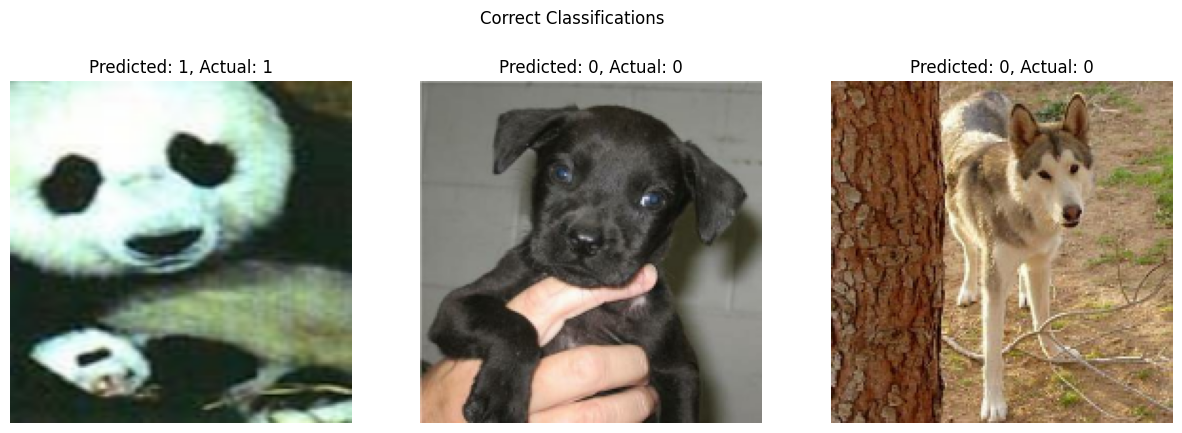

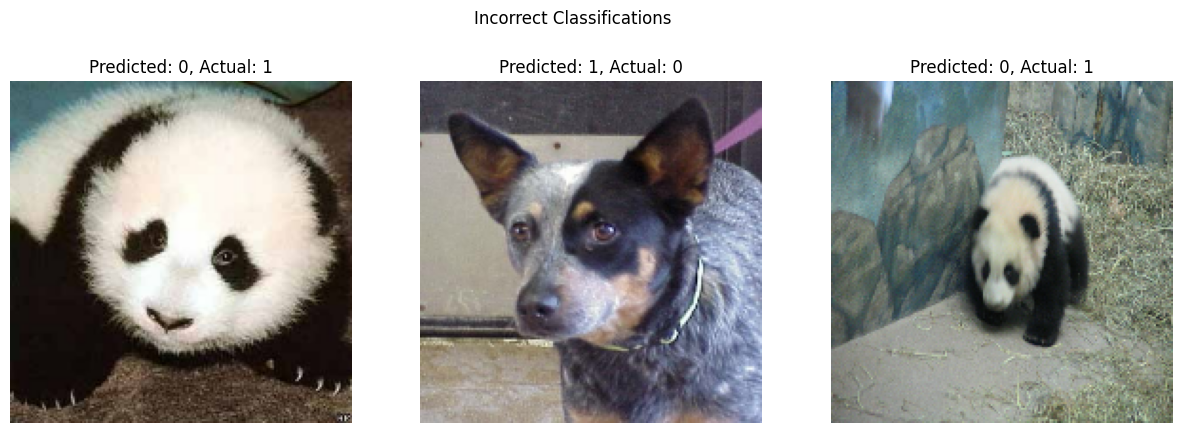

In [42]:
# Assuming test_dataset is batched: (image, label)
predictions = []
labels = []
images = []
for img, label in test_dataset.take(10):  # Adjust the number of batches to suit your dataset size
    pred = pvdm3.predict(img)
    pred = np.round(pred).astype(int).flatten()  # Round predictions to 0 or 1 for binary classification
    predictions.extend(pred)
    labels.extend(label.numpy())
    images.extend(img.numpy())

# Convert lists to arrays for easier manipulation
predictions = np.array(predictions)
labels = np.array(labels)
images = np.array(images)

# Find indices of correct and incorrect predictions
correct_indices = np.where(predictions == labels)[0]
incorrect_indices = np.where(predictions != labels)[0]

# Function to plot images
def plot_images(indices, title):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices[:3], start=1):  # Plot up to 3 images
        plt.subplot(1, 3, i)
        # Rescale the images back to 0-255 and convert to integers for display
        image_to_display = (images[idx] * 255).astype("uint8")
        plt.imshow(image_to_display)
        plt.title(f"Predicted: {predictions[idx]}, Actual: {labels[idx]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


# Plot correct classifications
plot_images(correct_indices, "Correct Classifications")

# Plot incorrect classifications
plot_images(incorrect_indices, "Incorrect Classifications")

In [44]:
# RANDOM CLASSIFIER
# Assuming test_dataset is batched
num_samples = sum([batch[0].shape[0] for batch in test_dataset])

# Generate random predictions for binary classification
random_predictions_binary = tf.random.uniform(shape=[num_samples], minval=0, maxval=2, dtype=tf.int32)

# Collect actual labels from the dataset
actual_labels = []
for _, label in test_dataset:
    # Flatten the batch of labels into a list
    actual_labels.extend(label.numpy().flatten())  # Use .flatten() to ensure it's a flat list

# Ensure actual_labels is a TensorFlow tensor to match random_predictions_binary
actual_labels = tf.convert_to_tensor(actual_labels, dtype=tf.int32)

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(random_predictions_binary, actual_labels), tf.float32))
print(f"Random Classifier Accuracy: {accuracy.numpy()}")

Random Classifier Accuracy: 0.44999998807907104
